# Thura Tun

### The Sparks Foundation | GRIPJULY22 | 
### Computer vision & IoT Internship 2nd Task

### Task#4 - Detection of Face Mask

#### Notebook-file1: Train Face Mask Classifier with Keras/TensorFlow and using Transfer Learning with MobileNetV2 as baseModel

In [1]:
# Import packages

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# Initialize learning rate, number of epoch, batch size, and dataset path

LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

dataset = '/content/drive/MyDrive/TSF-face-mask/dataset'

In [3]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO]: Loading Images....")
imagePaths = list(paths.list_images(dataset))

data = []
labels = []

[INFO]: Loading Images....


In [4]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the file name
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224 * 224) and preprocess it 
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
 
	# update data and label list
	data.append(image)
	labels.append(label)

In [5]:
# convert the data and labels from lists to NumPy array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
# partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
# Data Augmentation with training image generator
DataAugmentation = ImageDataGenerator(
                    rotation_range=20,
                    zoom_range=0.15,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.15,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer set are left off
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3))) 

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
# construct the head of model that will be place on the top of the baseModel
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

In [11]:
# place the head FC model on the top of the baseModel (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# Loop over all the layers in baseModel, and FREEZE them so they will not be updated during th 1st training process
for layer in baseModel.layers:
  layer.trainable = False

In [13]:
# compile our model
print("[INFO]: Compiling model...")

opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, 
              metrics=["accuracy"])

print("Done!!!")

[INFO]: Compiling model...
Done!!!


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# check for GPU availability
print("GPU", "available Yesss!!!" if tf.config.list_physical_devices("GPU") else "GPU not available!!!")

GPU available Yesss!!!


In [15]:
# train the head of the network
print("[INFO] training head...")
trainModel = model.fit(DataAugmentation.flow(trainX, trainY, batch_size=BATCH_SIZE),
											 steps_per_epoch=len(trainX) // BATCH_SIZE,
											 validation_data=(testX, testY),
											 validation_steps=len(testX) // BATCH_SIZE,
											 epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 26s 372ms/step - loss: 0.5885 - accuracy: 0.7687 - val_loss: 0.2679 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 15s 431ms/step - loss: 0.2303 - accuracy: 0.9625 - val_loss: 0.1242 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 11s 323ms/step - loss: 0.1307 - accuracy: 0.9794 - val_loss: 0.0757 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 14s 427ms/step - loss: 0.0834 - accuracy: 0.9869 - val_loss: 0.0545 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 12s 338ms/step - loss: 0.0699 - accuracy: 0.9888 - val_loss: 0.0421 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 14s 401ms/step - loss: 0.0553 - accuracy: 0.9908 - val_loss: 0.0351 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 14s 424ms/step - loss: 0.0428 - accuracy: 0.9963 - val_loss: 0.029

In [23]:
# Make prediction on the testing set
print("[INFO]: Evaluating network......")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

[INFO]: Evaluating network......


In [25]:
# For each image in testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [31]:
# show a formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
      target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [32]:
pwd

'/content'

In [33]:
# Save the model
print("[INFO]: Saving the mask detector model....")
model.save("/content/drive/MyDrive/TSF-face-mask/mask-detector-model.model", save_format="h5")
print("Done!!!")

[INFO]: Saving the mask detector model....
Done!!!


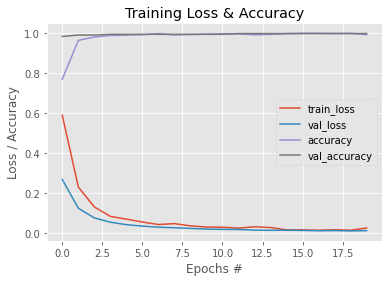

In [37]:
# Plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), trainModel.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), trainModel.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), trainModel.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), trainModel.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss & Accuracy")
plt.xlabel("Epochs #")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="center right")
plt.savefig("/content/drive/MyDrive/TSF-face-mask/evaluation.png")